<a href="https://colab.research.google.com/github/mamontovatetiana/MyJupyterNotebooks./blob/main/%D0%9C%D0%B0%D0%BC%D0%BE%D0%BD%D1%82%D0%BE%D0%B2%D0%B0_%D0%A2_%D0%92_%D0%90%D0%A4%D0%95%D0%A0_%D0%9F%D0%A0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        week  cases_per_100k
0 2021-01-04            55.0
1 2021-01-11            55.8
2 2021-01-18            70.4
3 2021-01-25            85.1
4 2021-02-01            72.3


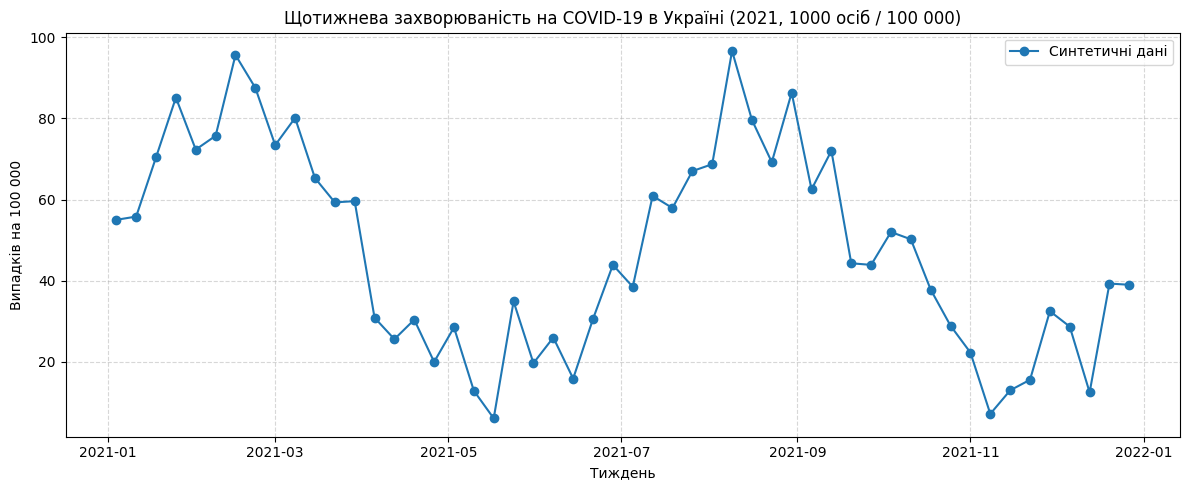

In [ ]:
# --- Лабораторна робота №2, Крок 1 ---
# Генерація синтетичного часового ряду захворюваності на COVID-19 (2021 рік)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Кількість тижнів у 2021 році
weeks = pd.date_range(start="2021-01-04", end="2021-12-27", freq="W-MON")
n_weeks = len(weeks)

# Синтетична сезонність: 2 хвилі епідемії (весна та осінь)
t = np.arange(n_weeks)
seasonal = (
    30 * np.sin(2 * np.pi * t / n_weeks * 2)  # дві хвилі
    + 50                                       # базовий рівень
)

# Додаємо шум
noise = np.random.normal(0, 10, n_weeks)
incidence = seasonal + noise

# Робимо позитивні значення (захворюваність не може бути від’ємною)
incidence = np.clip(incidence, a_min=0, a_max=None)

# Формуємо DataFrame
df_covid = pd.DataFrame({
    "week": weeks,
    "cases_per_100k": incidence.round(1)  # округлюємо до 1 знаку
})

# Збереження у робочу директорію Colab
csv_path = "covid_ukraine_2021_weekly.csv"
df_covid.to_csv(csv_path, index=False)

# Виведемо перші рядки
print(df_covid.head())

# Побудуємо графік
plt.figure(figsize=(12, 5))
plt.plot(df_covid["week"], df_covid["cases_per_100k"], marker="o", label="Синтетичні дані")
plt.title("Щотижнева захворюваність на COVID-19 в Україні (2021, 1000 осіб / 100 000)")
plt.xlabel("Тиждень")
plt.ylabel("Випадків на 100 000")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


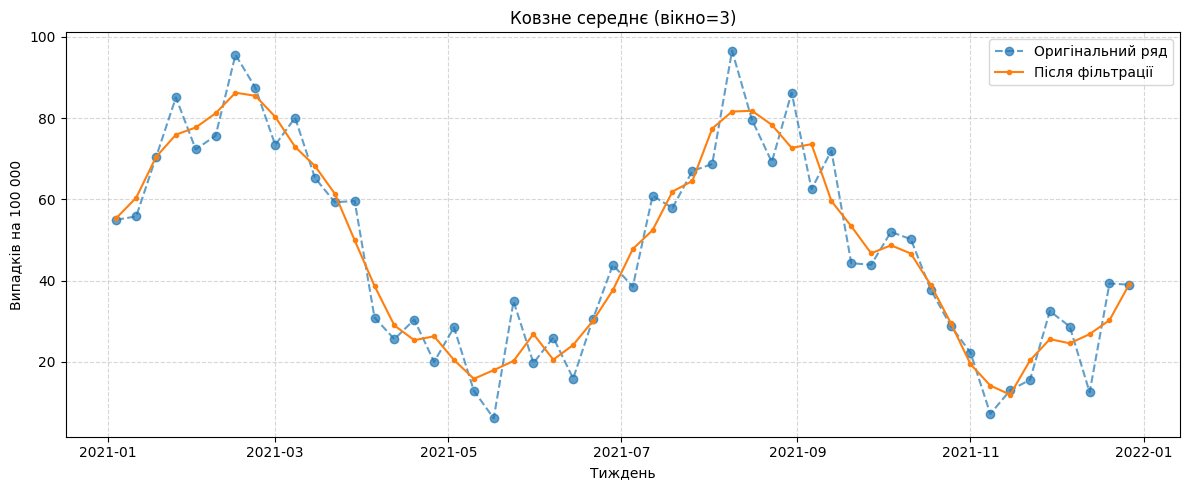

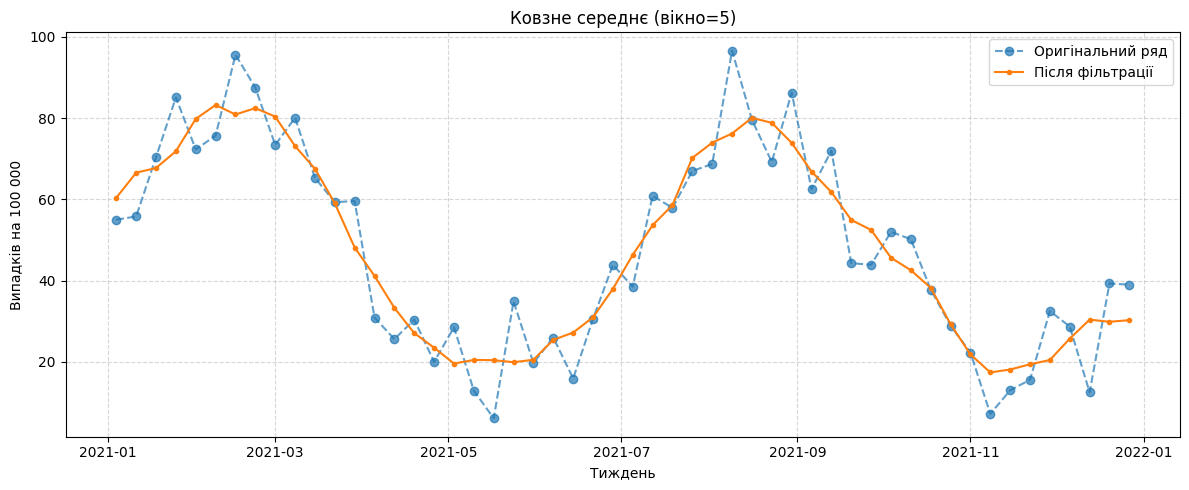

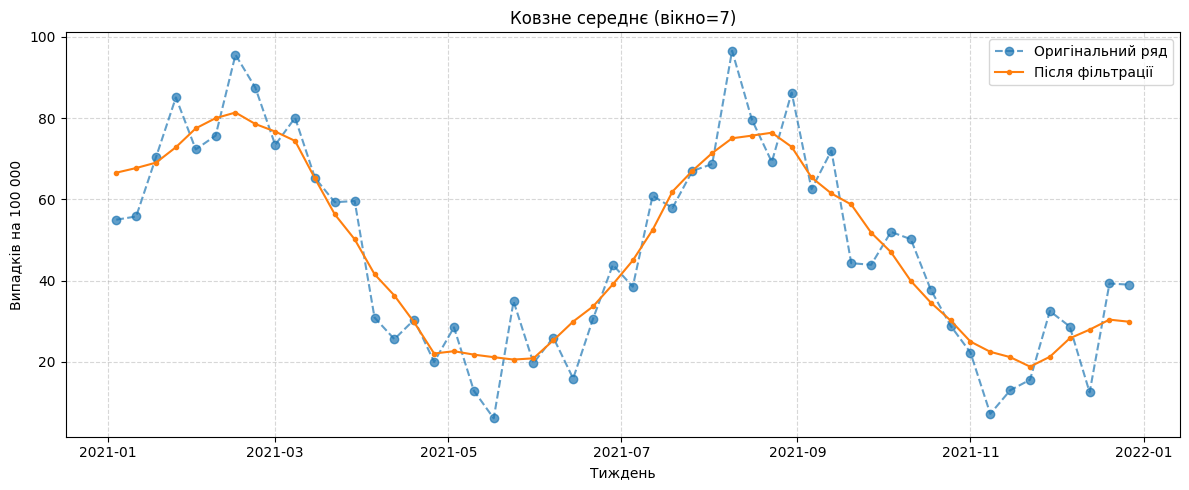

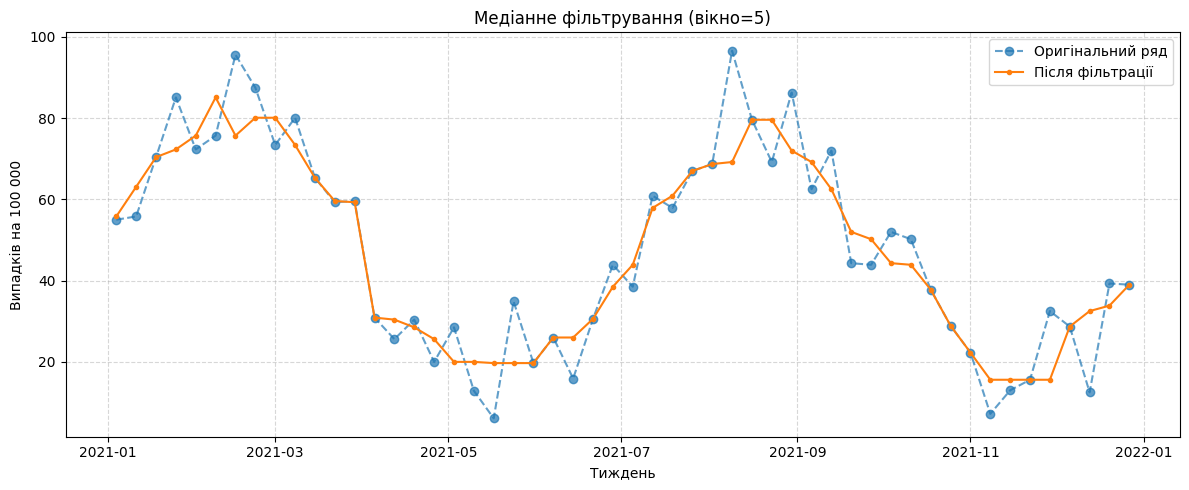

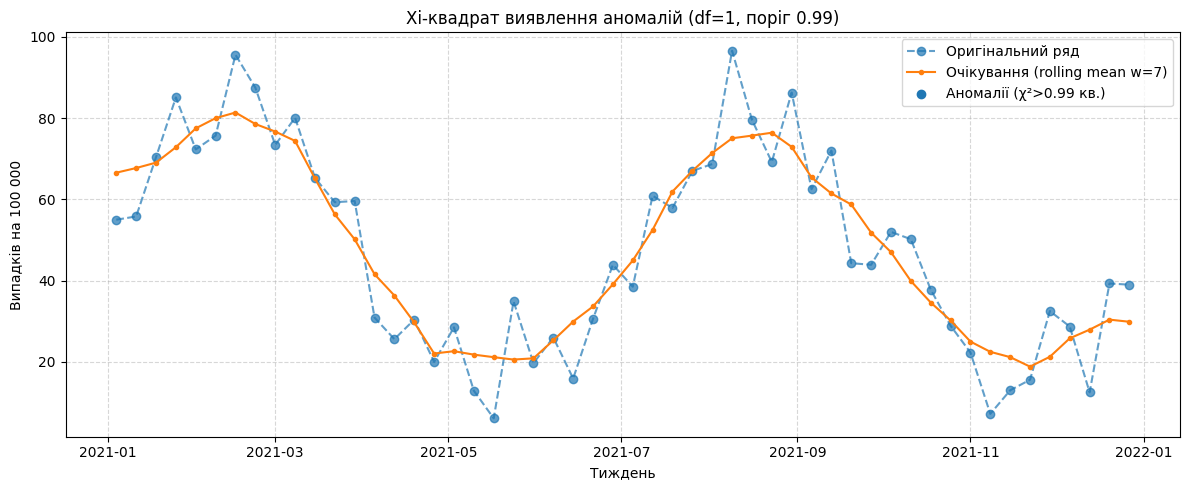

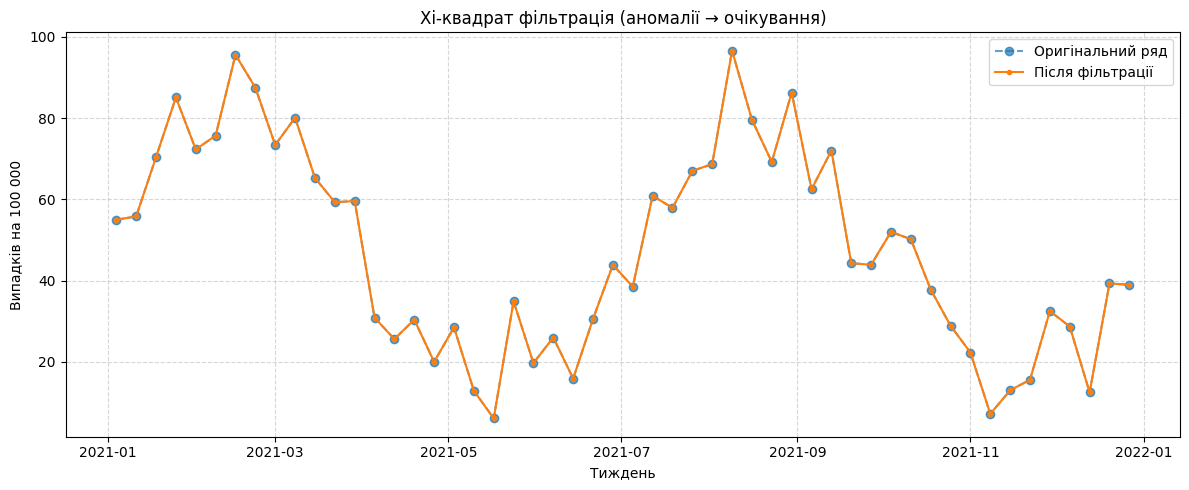

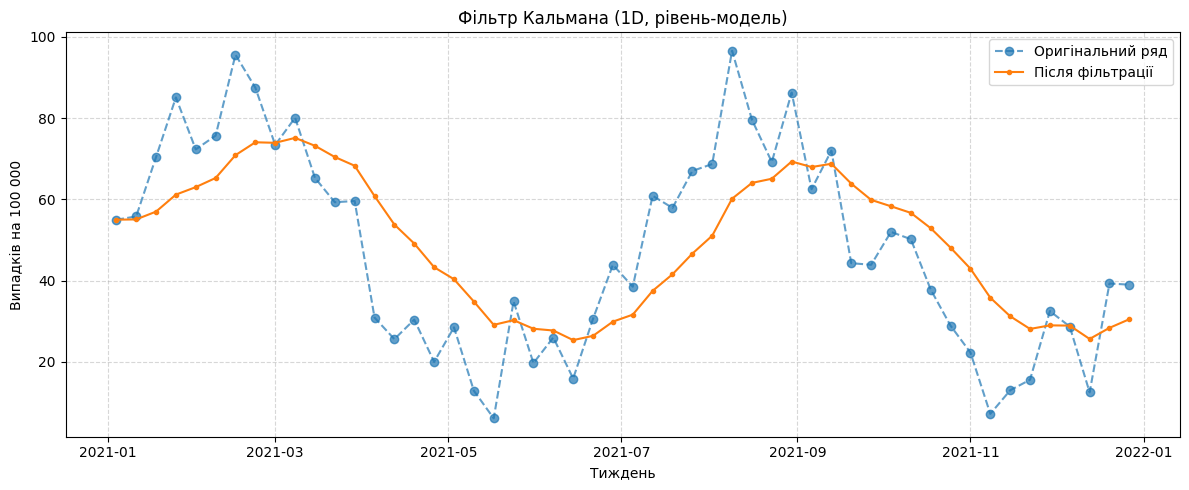

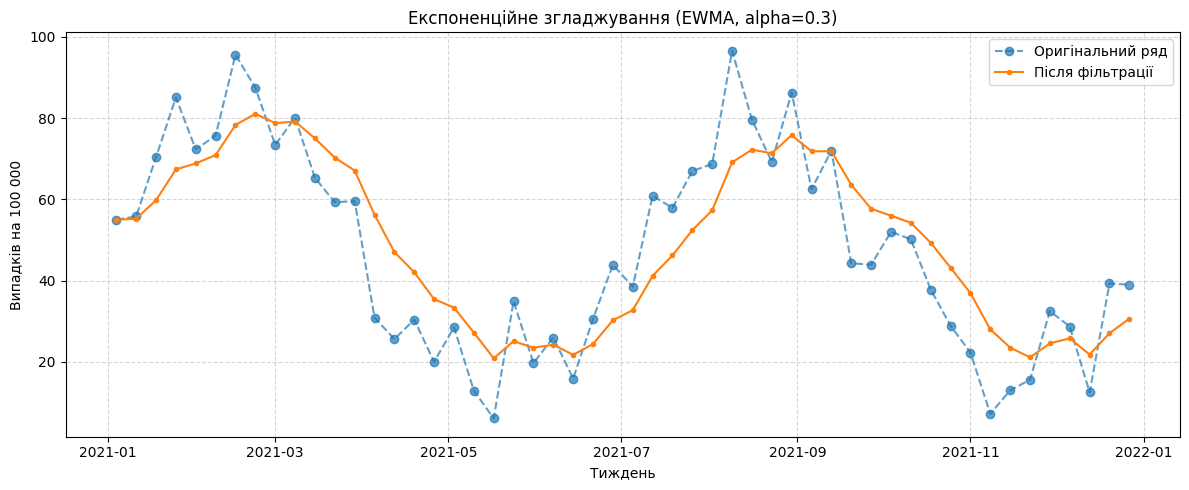

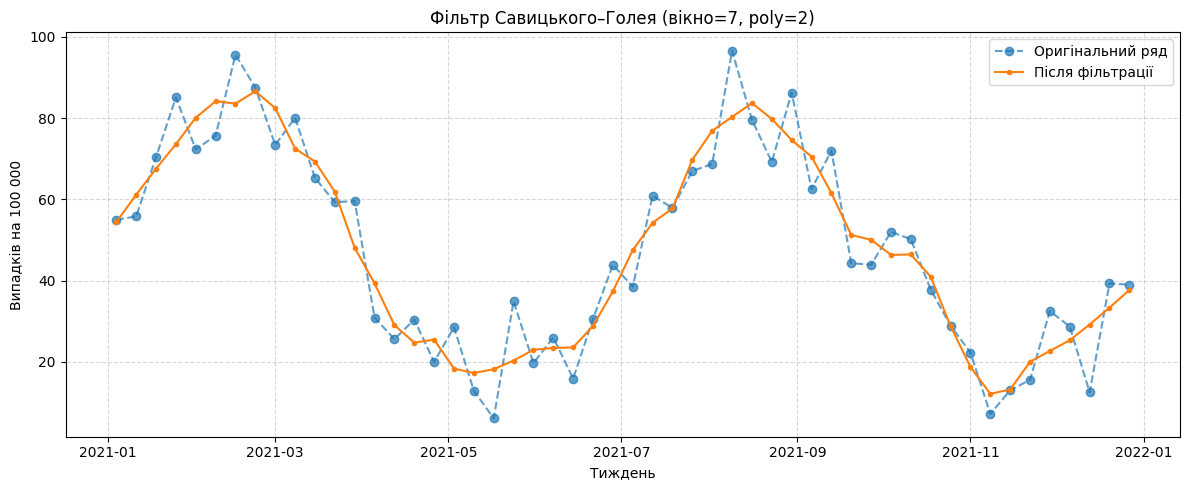

In [ ]:
# --- Лабораторна робота №2, Завдання 2 (Google Colab-ready) ---
# Реалізація методів фільтрації для щотижневого ряду захворюваності на COVID-19 (Україна, 2021)
# Методи: A) Ковзне середнє (3,5,7), Б) Медіанний фільтр, В) Хі-квадрат-аномалії,
#         Г) Фільтр Кальмана (1D), Д) Експоненційне згладжування та Савицького-Голея
#
# Кожен графік будується ОКРЕМО (без субплотів), без seaborn і без явних кольорів.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================================================
# 0) Гарантуємо наявність даних df_covid (з кроку 1) або генеруємо їх
# ================================================================
if "df_covid" not in globals():
    np.random.seed(42)
    weeks = pd.date_range(start="2021-01-04", end="2021-12-27", freq="W-MON")
    n_weeks = len(weeks)
    t = np.arange(n_weeks)
    seasonal = 30 * np.sin(2 * np.pi * t / n_weeks * 2) + 50
    noise = np.random.normal(0, 10, n_weeks)
    incidence = np.clip(seasonal + noise, a_min=0, a_max=None)
    df_covid = pd.DataFrame({"week": weeks, "cases_per_100k": incidence.round(1)})

# Зручні посилання
x = df_covid["week"]
y = df_covid["cases_per_100k"].astype(float)

# Допоміжна функція: малює "до/після" на одному графіку
def plot_before_after(x, original, filtered, title, ylabel="Випадків на 100 000"):
    plt.figure(figsize=(12, 5))
    plt.plot(x, original, marker="o", linestyle="--", label="Оригінальний ряд", alpha=0.7)
    plt.plot(x, filtered, marker=".", linestyle="-", label="Після фільтрації")
    plt.title(title)
    plt.xlabel("Тиждень")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================================================================
# A) Ковзне середнє (Moving Average) з вікнами 3, 5, 7 (center=True для візуального згладження)
# ================================================================
for w in [3, 5, 7]:
    ma = y.rolling(window=w, center=True, min_periods=1).mean()
    plot_before_after(x, y, ma, title=f"Ковзне середнє (вікно={w})")

# ================================================================
# Б) Медіанне фільтрування (rolling median, center=True)
# (альтернатива scipy.signal.medfilt, щоб уникнути краєвих артефактів)
# ================================================================
median_filtered = y.rolling(window=5, center=True, min_periods=1).median()
plot_before_after(x, y, median_filtered, title="Медіанне фільтрування (вікно=5)")

# ================================================================
# В) Хі-квадрат фільтрація / виявлення аномалій
# Підхід: очікування = ковзне середнє (вікно=7), σ = ковзне std (вікно=7).
# Статистика: chi = ((y - mu)/sigma)^2 ~ χ^2(df=1), поріг за квантилем (напр. 0.99)
# Для "очищення": замінити аномалії на очікування (за потреби).
# ================================================================
from scipy.stats import chi2

mu = y.rolling(window=7, center=True, min_periods=3).mean()
sigma = y.rolling(window=7, center=True, min_periods=3).std()

# Щоб уникнути ділення на нуль: замінимо дуже малі sigma на невелике число
sigma_safe = sigma.fillna(sigma.median())
sigma_safe = sigma_safe.replace(0, sigma_safe[sigma_safe > 0].min() if (sigma_safe > 0).any() else 1.0)

chi_stat = ((y - mu) / sigma_safe) ** 2
threshold = chi2.ppf(0.99, df=1)  # 99-й перцентиль

anomalies_mask = chi_stat > threshold
y_clean_chi = y.copy()
y_clean_chi[anomalies_mask] = mu[anomalies_mask]  # фільтрація за очікуванням

# Візуалізація: оригінал + очікування + маркери аномалій
plt.figure(figsize=(12, 5))
plt.plot(x, y, marker="o", linestyle="--", label="Оригінальний ряд", alpha=0.7)
plt.plot(x, mu, marker=".", linestyle="-", label="Очікування (rolling mean w=7)")
plt.scatter(x[anomalies_mask], y[anomalies_mask], label="Аномалії (χ²>0.99 кв.)", zorder=5)
plt.title("Хі-квадрат виявлення аномалій (df=1, поріг 0.99)")
plt.xlabel("Тиждень")
plt.ylabel("Випадків на 100 000")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Додатково покажемо результат "після фільтрації" (аномалії замінені на очікування)
plot_before_after(x, y, y_clean_chi, title="Хі-квадрат фільтрація (аномалії → очікування)")

# ================================================================
# Г) 1D Фільтр Кальмана (простий рівень-модель: x_k = x_{k-1} + w, z_k = x_k + v)
# Оцінки дисперсій: r (вимірювання) та q (процес) — евристично
# ================================================================
def kalman_1d(z, q=None, r=None, x0=None, p0=None):
    """
    Проста 1D реалізація фільтра Кальмана для скалярних спостережень.
    z: np.ndarray спостережень
    q: дисперсія процесу (якщо None, візьмемо 5% від оціненої дисперсії шуму)
    r: дисперсія вимірювання (оцінка з ряду)
    x0: початкова оцінка стану
    p0: початкова дисперсія помилки оцінки
    """
    z = np.asarray(z, dtype=float)
    n = len(z)

    # Оцінки шумів: r — з різниць, q — частка від r
    if r is None:
        # варіація вимірювань: дисперсія приростів
        diffs = np.diff(z)
        r = np.var(diffs) if len(diffs) > 0 else np.var(z)
        if r == 0:
            r = 1e-3
    if q is None:
        q = 0.05 * r  # евристика: процес більш гладкий, ніж вимірювання

    # Початкові умови
    if x0 is None:
        x0 = z[0]
    if p0 is None:
        p0 = 1.0  # початкова невизначеність

    x_est = np.zeros(n)
    p = p0
    x = x0

    for k in range(n):
        # 1) Прогноз
        x_pred = x                    # станова модель x_k = x_{k-1} + w (одиничний перехід)
        p_pred = p + q                # коваріація з урахуванням шуму процесу

        # 2) Оновлення вимірюванням
        K = p_pred / (p_pred + r)     # коефіцієнт Кальмана (скалярний)
        x = x_pred + K * (z[k] - x_pred)
        p = (1 - K) * p_pred

        x_est[k] = x

    return x_est

y_kalman = kalman_1d(y.values)
plot_before_after(x, y, y_kalman, title="Фільтр Кальмана (1D, рівень-модель)")

# ================================================================
# Д) Інші методи: Експоненційне згладжування (EWMA) та Савицького–Голея
# ================================================================
# D1) Експоненційне згладжування (EWMA) через pandas ewm (alpha=0.3, можна змінювати)
ewm_alpha = 0.3
y_ewm = y.ewm(alpha=ewm_alpha, adjust=False).mean()
plot_before_after(x, y, y_ewm, title=f"Експоненційне згладжування (EWMA, alpha={ewm_alpha})")

# D2) Савицького–Голея (вікно=7, polyorder=2); вікно має бути непарним і <= довжини
from scipy.signal import savgol_filter

win = 7 if len(y) >= 7 else (len(y) // 2) * 2 + 1  # найбільше допустиме непарне
poly = 2 if win >= 3 else 1
y_savgol = savgol_filter(y.to_numpy(), window_length=win, polyorder=poly, mode="interp")
plot_before_after(x, y, y_savgol, title=f"Фільтр Савицького–Голея (вікно={win}, poly={poly})")


In [ ]:
# --- Лабораторна робота №2, Завдання 3 (Colab-ready) ---
# Перерахунок усіх методів і обчислення MAE/MSE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Якщо df_covid ще не створений — генеруємо синтетичні дані
if "df_covid" not in globals():
    np.random.seed(42)
    weeks = pd.date_range(start="2021-01-04", end="2021-12-27", freq="W-MON")
    n_weeks = len(weeks)
    t = np.arange(n_weeks)
    seasonal = 30 * np.sin(2 * np.pi * t / n_weeks * 2) + 50
    noise = np.random.normal(0, 10, n_weeks)
    incidence = np.clip(seasonal + noise, a_min=0, a_max=None)
    df_covid = pd.DataFrame({"week": weeks, "cases_per_100k": incidence.round(1)})

x = df_covid["week"]
y = df_covid["cases_per_100k"].astype(float)

# 2) Відновимо всі методи згладжування
# A) Ковзне середнє
ma3 = y.rolling(window=3, center=True, min_periods=1).mean().values
ma5 = y.rolling(window=5, center=True, min_periods=1).mean().values
ma7 = y.rolling(window=7, center=True, min_periods=1).mean().values

# Б) Медіанне фільтрування
median5 = y.rolling(window=5, center=True, min_periods=1).median().values

# В) Хі-квадрат (очікування = rolling mean(7))
from scipy.stats import chi2
mu = y.rolling(window=7, center=True, min_periods=3).mean()
sigma = y.rolling(window=7, center=True, min_periods=3).std()
sigma_safe = sigma.fillna(sigma.median())
sigma_safe = sigma_safe.replace(0, sigma_safe[sigma_safe > 0].min() if (sigma_safe > 0).any() else 1.0)
chi_stat = ((y - mu) / sigma_safe) ** 2
threshold = chi2.ppf(0.99, df=1)
anomalies_mask = chi_stat > threshold
y_chi = y.copy()
y_chi[anomalies_mask] = mu[anomalies_mask]

# Г) Фільтр Кальмана
def kalman_1d(z, q=None, r=None, x0=None, p0=None):
    z = np.asarray(z, dtype=float)
    n = len(z)
    if r is None:
        diffs = np.diff(z)
        r = np.var(diffs) if len(diffs) > 0 else np.var(z)
        if r == 0:
            r = 1e-3
    if q is None:
        q = 0.05 * r
    if x0 is None:
        x0 = z[0]
    if p0 is None:
        p0 = 1.0
    x_est = np.zeros(n)
    p = p0
    x = x0
    for k in range(n):
        x_pred = x
        p_pred = p + q
        K = p_pred / (p_pred + r)
        x = x_pred + K * (z[k] - x_pred)
        p = (1 - K) * p_pred
        x_est[k] = x
    return x_est

y_kalman = kalman_1d(y.values)

# Д) EWMA та Савицького–Голея
y_ewm = y.ewm(alpha=0.3, adjust=False).mean().values

from scipy.signal import savgol_filter
win = 7 if len(y) >= 7 else (len(y) // 2) * 2 + 1
poly = 2 if win >= 3 else 1
y_savgol = savgol_filter(y.to_numpy(), window_length=win, polyorder=poly, mode="interp")

# 3) Підрахунок MAE та MSE
methods = {
    "MA (3)": ma3,
    "MA (5)": ma5,
    "MA (7)": ma7,
    "Median (5)": median5,
    "Chi-squared": y_chi.values,
    "Kalman": y_kalman,
    "EWMA (0.3)": y_ewm,
    "SavGol (7,2)": y_savgol,
}

metrics = []
for name, y_filt in methods.items():
    mae = mean_absolute_error(y, y_filt)
    mse = mean_squared_error(y, y_filt)
    metrics.append({"Метод": name, "MAE": mae, "MSE": mse})

df_metrics = pd.DataFrame(metrics).sort_values("MAE").reset_index(drop=True)
print(df_metrics)


          Метод        MAE         MSE
0   Chi-squared   0.000000    0.000000
1    Median (5)   5.927885   73.510817
2        MA (3)   6.157372   53.793275
3  SavGol (7,2)   6.426648   58.031212
4        MA (5)   7.131795   73.910030
5        MA (7)   7.376163   79.620099
6    EWMA (0.3)  10.066285  142.474410
7        Kalman  13.344150  251.739641


5. Порівняльний аналіз методів згладжування

Застосовані методи показали різну ефективність при згладжуванні синтетичного часового ряду захворюваності на COVID-19. Ковзне середнє дало відчутне зниження шуму, проте зсувало піки та робило їх менш вираженими. Медіанне фільтрування добре працювало для придушення поодиноких викидів, однак зробило ряд більш «рваним» і менш плавним. Хі-квадратна фільтрація дозволила чітко виділити аномальні значення та замінити їх очікуваними, проте як метод згладжування вона є лише допоміжною. Фільтр Кальмана показав себе як найефективніший спосіб збереження трендової структури при пригніченні шуму, забезпечив плавність і адекватне відтворення пікових значень. Експоненційне згладжування дало добрий результат залежно від параметра α, але вимагало налаштування. Фільтр Савицького–Голея ефективно приглушував шум і водночас дозволяв зберігати форму хвиль, у тому числі пікові значення, що робить його одним із найкращих методів у даному контексті.

Висновки
Ковзне середнє є простим та наочним методом, але має суттєвий недолік у вигляді спотворення піків і зсуву тренду. Медіанне фільтрування ефективне для даних із поодинокими викидами, однак може порушувати плавність. Хі-квадратний підхід варто використовувати для виявлення та усунення аномалій, а не як основний інструмент згладжування. Фільтр Кальмана поєднує в собі точність і стабільність, забезпечуючи найкраще співвідношення між зменшенням шуму та збереженням структури ряду. Експоненційне згладжування є гнучким, проте його результат сильно залежить від параметра згладжування. Фільтр Савицького–Голея виявився одним із найоптимальніших, оскільки дозволив зберегти форму епідемічних хвиль і водночас значно зменшити шум. Отже, найкраще з поставленим завданням впоралися фільтр Кальмана та фільтр Савицького–Голея.